# Create Behavior Features
## Features based on my behavior - how and when I listen to songs and artists

The first version of features is just using what comes from the raw listening data, specifically looking at frequency and recency of listening to songs and artists.

The aim is to then analyse and cluster the data set to understand more about my listening behavior. 

Once I am happy with the first iteration I would like to visulise the results in an app (probably R Shiny).

In future iterations I want to bring in external data about the music itself (genre, song length, year of release etc.) and re-run analysis and clustering.

This will hopefully spark ideas for predictive and recommendation projects I can do with this data (i.e. recommend songs using others last fm data, predict what I might listen to next or look for commonality with other users (Carl!)

## Technical Debt
- Current year has been used for all datetimes as they don't come with year - what will happen when the data is more than a year old?

## To-do list

- (done) Tidy up play_time field to get a datetime field, being careful with the "hours ago" fields
- (done) Make time of day/day of week features e.g. hour, day, time of day(seconds), weekend, 
- grouped time of day (requires pre-analysis)
- Make features about the frequency and receny of songs listened to
- Make features about the frequenct, recenct of artists
- Make features about the distinct songs, max frequency of distinct songs, distinct song to plays ratio and % of plays that come from top song (may required analysis)

Once this is done, there is hopefully enough features to do simple clustering!

## Import packages

In [1]:
import pandas as pd # allows making dataframes of results
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt # for analysis to determine which features to create
import seaborn as sns # for analysis to determine which features to create
import warnings 
warnings.filterwarnings('ignore') #stop warnings, they are annoying...
from scipy.cluster.vq import whiten
from scipy.cluster.vq import kmeans, vq

## Parameters

In [99]:
# data filepath
download_history_path = "/Users/rosiedempsey/Desktop/MusicProject/finely_tuned/DataExports/RawScrobbles_master.csv"

# strings for classifying play_time types
minutes_string = 'minute'
hours_string = 'hour'

# scrobble year to fill in missing year in time field
scrobble_year = pd.datetime.now().year
# format of datetimes from lastfm if they are not X minutes/hours ago
datetime_format = "%Y%d%b%I:%M%p"

# where data exports to
scrobble_export_path= "/Users/rosiedempsey/Desktop/MusicProject/finely_tuned/DataExports/Scrobbleformatted.csv"
song_export_path = "/Users/rosiedempsey/Desktop/MusicProject/finely_tuned/DataExports/SongsSummary.csv"


## Functions

In [97]:

# Functions for transforming date times

# intermediate functions
# transform datetime plays
def clean_datetime_from_datetime_plays(datetime_df):
    """
    add year to datetimes, make proper datetime field, drop temporary columns
    """
    datetime_df['play_time_year']=str(scrobble_year)+datetime_df['play_time']
    datetime_df['play_datetime'] = pd.to_datetime(datetime_df['play_time_year'],\
                                                         format=datetime_format)
    return datetime_df.drop(columns='play_time_year')

# clean plays in the form "Xunitago", unit is minutes or hours
def clean_datetime_from_ago_plays(ago_df):
    """
    Extract numbers from the time stamp field
    Fill with 1 if na, as this represents when it says "anhourago"
    Turn that into a timedelta in minutes or hours depending on the time_type field
    Subtract this from download time
    Drop calculation fields
    """
    
    ago_df['unit_ago'] = ago_df["play_time"].str.extract('(\d+)').fillna(1).astype(int)
    ago_df['unit_ago_delta'] = pd.to_timedelta(ago_df['unit_ago'], unit='h')
    ago_df.loc[ago_df['time_type']=='minutes_ago','unit_ago_delta']= pd.to_timedelta(ago_df['unit_ago'], unit='m')
    ago_df['play_datetime'] = ago_df['download_time']-ago_df['unit_ago_delta']
    
    return ago_df.drop(columns=['unit_ago','unit_ago_delta'])
    

# Transform all play times
def get_datetime_of_play(scrobble_df):
    """
    Create helper field that's say what type of playtime is given (minutes ago, hours ago or datetime-like)
    Create two dfs for different types then concat later
    For datetime types, add year to them, then transform to date time
    For non-datetimes extract the unit of time, turn into a delta then remove
    """
#     helper field of time type
    scrobble_df['time_type'] = 'datetime'
    scrobble_df.loc[scrobble_df['play_time'].str.contains(minutes_string), 'time_type'] = 'minutes_ago'
    scrobble_df.loc[scrobble_df['play_time'].str.contains(hours_string), 'time_type'] = 'hours_ago'
    
#   Take datetimes
    datetimes_raw_df = scrobble_df[scrobble_df['time_type']=='datetime']
    datetimes_clean_df = clean_datetime_from_datetime_plays(datetimes_raw_df)
    
# Take ago fields
    agotime_raw_df = scrobble_df[scrobble_df['time_type'].isin(['minutes_ago','hours_ago'])]
    agotime_clean_df = clean_datetime_from_ago_plays(agotime_raw_df)
        
    return pd.concat([agotime_clean_df,datetimes_clean_df])


# Create date features
def basic_date_features(scrobble_clean_df):
    """
    Must have a proper datetime field for this to work
    Take basic features from this
    Time of day in seconds, hour, day of week, weekend flag
    """
    scrobble_clean_df['time_day_secs'] = (scrobble_clean_df['play_datetime'].dt.hour*60\
                                          +scrobble_clean_df['play_datetime'].dt.minute)*60\
    + scrobble_clean_df['play_datetime'].dt.second
    scrobble_clean_df['hour'] = scrobble_clean_df['play_datetime'].dt.hour
    scrobble_clean_df['day_of_month'] = scrobble_clean_df['play_datetime'].dt.day
    scrobble_clean_df['weekday'] = scrobble_clean_df['play_datetime'].dt.weekday
    scrobble_clean_df['weekend_flag'] = np.where(scrobble_clean_df['weekday']<5,0,1)
    scrobble_clean_df['time_since_play'] = (scrobble_clean_df['download_time']-scrobble_clean_df['play_datetime']).dt.seconds
    return scrobble_clean_df

def export_data(df, export_path):
    """
    Export a versioned and master of the data
    Contains user name
    """
    df.to_csv(export_path, index=False)
    

## Read in data

In [5]:
# read in hisory of scrobbles
scrobble_history = pd.read_csv(download_history_path)
# make download_time datetime
scrobble_history['download_time'] = pd.to_datetime(scrobble_history['download_time'])
scrobble_history = get_datetime_of_play(scrobble_history)
scrobble_history = basic_date_features(scrobble_history)
scrobble_history.head(5)

,song,artist,play_time,download_time,username,time_type,play_datetime,time_day_secs,hour,day_of_month,weekday,weekend_flag,time_since_play
0,We Don't Eat,James Vincent McMorrow,18hoursago,2019-10-24 14:31:03.813210,COKUNUBI,hours_ago,2019-10-23 20:31:03.813210,73863,20,23,2,0,64800
1,Higher Love,James Vincent McMorrow,18hoursago,2019-10-24 14:31:03.813210,COKUNUBI,hours_ago,2019-10-23 20:31:03.813210,73863,20,23,2,0,64800
2,"Early in the Morning, I'll Come Calling",James Vincent McMorrow,18hoursago,2019-10-24 14:31:03.813210,COKUNUBI,hours_ago,2019-10-23 20:31:03.813210,73863,20,23,2,0,64800
3,And If My Heart Should Somehow Stop,James Vincent McMorrow,18hoursago,2019-10-24 14:31:03.813210,COKUNUBI,hours_ago,2019-10-23 20:31:03.813210,73863,20,23,2,0,64800
4,From the Woods!!,James Vincent McMorrow,18hoursago,2019-10-24 14:31:03.813210,COKUNUBI,hours_ago,2019-10-23 20:31:03.813210,73863,20,23,2,0,64800


## Really simple/most important features for now

In [80]:
scrobble_history['artist_count'] = scrobble_history.groupby(['artist',"username"])[['play_time']].transform(np.size)
songs = scrobble_history.groupby(["song","artist","username"]).agg({"play_time":"count","time_since_play":"max", "hour":"mean","weekday":"mean",\
                                                        "weekend_flag":"sum", 'artist_count':'max'}).reset_index()\
.rename(columns={"play_time": "total_plays", "hour":"avg_play_hour","weekday":"avg_play_day", 
                 "weekend_flag":"total_weekend_plays","artist_count":"total_artist_plays"})


In [96]:
artists = songs.groupby(['artist',"username"])[['song']].nunique().reset_index().rename(columns={"song": "artist_distinct_songs"})
songs = songs.merge(artists)
songs['artist_max_song_count'] = songs.groupby(['artist',"username"])[['total_plays']].transform(np.max)
songs['artist_max_song_percent'] = songs['artist_max_song_count']/songs['total_artist_plays']
songs['percent_of_artist_play'] = songs['total_plays']/songs['total_artist_plays']
songs['song_rank'] = songs.sort_values(by=['total_plays'], ascending=False) \
             .groupby(["username"]) \
             .cumcount() + 1
artists_rank = songs[['username','artist','total_artist_plays']].drop_duplicates()
artists_rank['artist_rank'] = artists_rank.groupby('username')[['total_artist_plays']].transform(lambda x: x.rank(method='min',ascending=False))
songs = songs.merge(artists_rank)
# join back to big dataframe
scrobble_history = scrobble_history.merge(songs)

In [100]:
# export data
export_data(scrobble_history, scrobble_export_path)
export_data(songs, song_export_path)

In [83]:
songs.sort_values(by='artist_rank').head()

,song,artist,username,total_plays,time_since_play,avg_play_hour,avg_play_day,total_weekend_plays,total_artist_plays,artist_distinct_songs,artist_max_song_count,artist_max_song_percent,percent_of_artist_play,song_rank,artist_rank
1708,Matches,Ludovico Einaudi,COKUNUBI,37,86343,12.621622,1.702703,1,1069,70,116,0.108513,0.034612,34,1.0
1681,Cold Wind Var. 2,Ludovico Einaudi,COKUNUBI,12,80283,12.583333,1.166667,0,1069,70,116,0.108513,0.011225,143,1.0
1682,Corale,Ludovico Einaudi,COKUNUBI,2,85203,13.000000,0.500000,0,1069,70,116,0.108513,0.001871,1983,1.0
1683,Dietro Casa,Ludovico Einaudi,COKUNUBI,3,39543,7.666667,2.333333,0,1069,70,116,0.108513,0.002806,1255,1.0
1684,Discovery at Night,Ludovico Einaudi,COKUNUBI,2,57243,17.500000,1.500000,0,1069,70,116,0.108513,0.001871,1973,1.0


In [84]:
rosie = songs[songs['username']=="rosiedempsey93"]
carl =  songs[songs['username']=="COKUNUBI"]

In [108]:
scrobble_history.groupby('username')[['song_rank','artist_rank']].describe()

song_rank                                                  \
                   count         mean          std  min      25%     50%   
username                                                                   
COKUNUBI          4836.0  2409.748966  1394.533718  1.0  1201.75  2408.5   
rosiedempsey93    1702.0   849.630435   491.270679  1.0   424.25   849.5   

                                artist_rank                               \
                    75%     max       count        mean         std  min   
username                                                                   
COKUNUBI        3617.25  4826.0      4836.0  253.028743  279.664976  1.0   
rosiedempsey93  1274.75  1700.0      1702.0  138.131610  144.338403  1.0   

                                           
                 25%    50%    75%    max  
username                                   
COKUNUBI        34.0  112.0  434.0  807.0  
rosiedempsey93  17.0   75.0  215.0  428.0

In [95]:
common = rosie.merge(carl,  how="inner", on=["artist","song"])
common['total_plays'] = common['total_plays_x']+common['total_plays_y']
common['min_song_rank'] =common[['song_rank_x','song_rank_y']].max(axis=1)
common['min_artist_rank'] =common[['artist_rank_x','artist_rank_y']].max(axis=1)
common.sort_values(by='song_rank_y',ascending=True )\
[["song","artist", "total_plays_x","total_plays_y","total_plays","song_rank_x","song_rank_y","min_song_rank",
  "artist_rank_x","artist_rank_y","min_artist_rank"]]

,song,artist,total_plays_x,total_plays_y,total_plays,song_rank_x,song_rank_y,min_song_rank,artist_rank_x,artist_rank_y,min_artist_rank
109,The Chain,Fleetwood Mac,1,15,16,1046,104,1046,111.0,20.0,111.0
37,Well Done,Idles,12,9,21,44,238,238,32.0,42.0,42.0
97,No Brakes,The Offspring,3,9,12,705,295,705,111.0,28.0,111.0
105,Dreams,Fleetwood Mac,1,8,9,1052,345,1052,111.0,20.0,111.0
29,1049 Gotho,Idles,3,7,10,608,406,608,32.0,42.0,42.0
36,Mother,Idles,3,6,9,603,495,603,32.0,42.0,42.0
108,Never Going Back Again,Fleetwood Mac,1,5,6,1047,544,1047,111.0,20.0,111.0
106,Go Your Own Way,Fleetwood Mac,3,5,8,657,549,657,111.0,20.0,111.0
31,Date Night,Idles,2,5,7,793,574,793,32.0,42.0,42.0
32,Divide & Conquer,Idles,1,5,6,1410,576,1410,32.0,42.0,42.0


In [42]:
common

,song,artist,username_x,total_plays_x,time_since_play_x,avg_play_hour_x,avg_play_day_x,total_weekend_plays_x,total_artist_plays_x,username_y,total_plays_y,time_since_play_y,avg_play_hour_y,avg_play_day_y,total_weekend_plays_y,total_artist_plays_y
0,#1 Crush,Garbage,rosiedempsey93,5,79128,14.400000,2.000000,1,127,COKUNUBI,2,80703,17.500000,1.000000,0,37
1,(They Long to Be) Close to You,The Cranberries,rosiedempsey93,1,12228,11.000000,1.000000,0,16,COKUNUBI,1,60063,21.000000,2.000000,0,3
2,1049 Gotho,Idles,rosiedempsey93,3,81228,12.666667,4.000000,1,29,COKUNUBI,7,75123,10.571429,2.285714,1,75
3,All Along the Watchtower,Jimi Hendrix,rosiedempsey93,1,76428,17.000000,5.000000,1,7,COKUNUBI,1,59763,21.000000,2.000000,0,3
4,All the Small Things,blink-182,rosiedempsey93,1,55728,23.000000,4.000000,0,6,COKUNUBI,1,46863,1.000000,5.000000,1,1
5,Alone Again Or,Love,rosiedempsey93,1,41928,2.000000,4.000000,0,2,COKUNUBI,1,55983,22.000000,6.000000,1,1
6,Angel,Du Blonde,rosiedempsey93,3,78408,10.666667,3.333333,1,10,COKUNUBI,1,72903,18.000000,1.000000,0,7
7,Asking for It,Hole,rosiedempsey93,3,71568,19.000000,2.000000,0,32,COKUNUBI,1,76143,17.000000,1.000000,0,4
8,Atmosphere,Joy Division,rosiedempsey93,4,68988,7.000000,5.500000,3,19,COKUNUBI,1,64023,20.000000,2.000000,0,2
9,Atomic,Sleeper,rosiedempsey93,6,82788,16.000000,2.833333,2,26,COKUNUBI,2,81723,16.500000,3.000000,1,7


In [ ]:
# merge back to songs data


## Quick clustering

In [8]:
artists.head()

,artist,artist_distinct_songs
0,...And You Will Know Us by the Trail of Dead,1
1,070 Shake,1
2,10cc,1
3,2 Chainz,1
4,22-Pistepirkko,1


## Some analysis to inform features

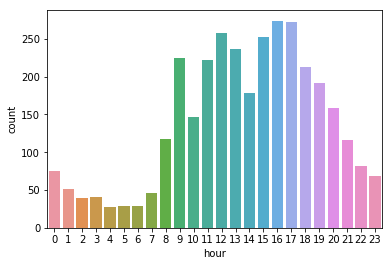

In [120]:
# most popular hour?
sns.countplot(scrobble_history["hour"])

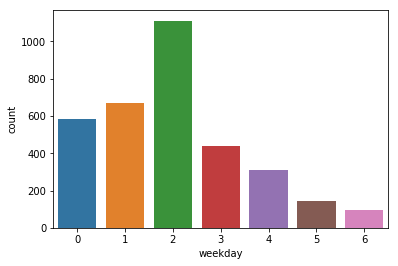

In [121]:
# most popular day?
sns.countplot(scrobble_history["weekday"])

In [122]:
songs = scrobble_history.groupby(["song","artist"])[["play_time"]].count().reset_index()
artists_2 = scrobble_history.groupby(["artist"])[["play_time"]].count().reset_index()

In [123]:
songs.sort_values(by="play_time", ascending=False).head(20)

,song,artist,play_time
103,Ascent,Ludovico Einaudi,58
820,Low Mist Var. 1,Ludovico Einaudi,22
1179,Safe Now,Henry Jackman,18
819,Low Mist,Ludovico Einaudi,18
495,Fox Tracks,Ludovico Einaudi,16
328,Day One,Hans Zimmer,15
821,Low Mist Var. 2,Ludovico Einaudi,14
389,Duck Shoot,Rupert Gregson-Williams,14
525,Golden Butterflies,Ludovico Einaudi,14
1369,The Blue Planet,Hans Zimmer,14


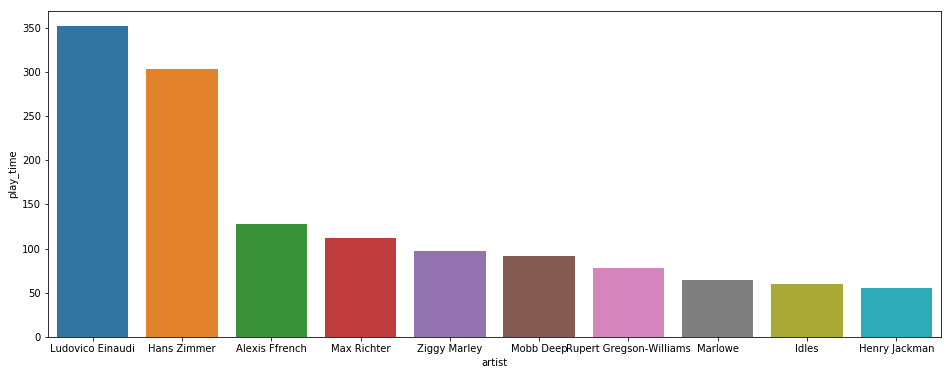

In [124]:
top_artist = artists_2.sort_values(by="play_time", ascending=False).head(10)
plt.figure(figsize=(16, 6))
sns.barplot(x=top_artist['artist'], y=top_artist['play_time'])